 #  Time Series Analysis Homework 2 - R08621110 閻大瑞

In [8]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.api import ExponentialSmoothing

## a
使用上次作業建立的函數，並且在每一個period都加入uniform noise

Text(0.5, 1.0, 'Simulate a time seires of 24 length with noise')

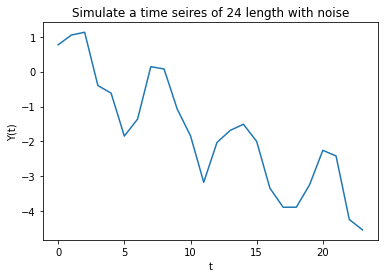

In [9]:
data = np.array(range(24))
data_sin = np.sin(data)
noise = np.random.uniform(0, 1, 24)
data_final = data_sin - 0.2*data + noise

plt.plot(data, data_final)
plt.xlabel('t')
plt.ylabel('Y(t)')
plt.title('Simulate a time seires of 24 length with noise')

## b
依據上圖，24個period中共有4個season，因此1個season中包含6個period\
接著進行deseasonalize:

Text(0.5, 1.0, 'time series after deseasonalize')

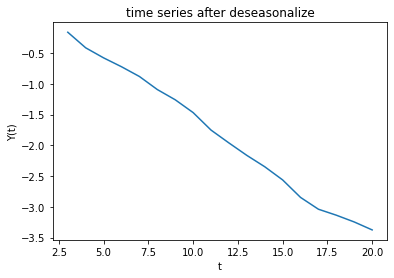

In [10]:
deseason_data = []
for i in range(3, 21):
    deseason = (data_final[i-3] + data_final[i+3] + 2*(data_final[i-2] + data_final[i-1] + data_final[i] + data_final[i+1] + data_final[i+2])) / 12
    deseason_data.append(deseason)

plt.plot(data[3:21], deseason_data)
plt.xlabel('t')
plt.ylabel('Y(t)')
plt.title('time series after deseasonalize')

## c
先計算seasonality，再計算其平均，為seasonality factor

In [11]:
seasonality = data_final[3:21] / deseason_data
season_factor = []
for i in range(6):
    factor = np.mean(seasonality[i] + seasonality[i+6] + seasonality[i+6*2])
    season_factor.append(factor)

season_factor

[4.0724496470704095,
 3.9064275246113693,
 6.275794319269548,
 4.154722848471344,
 1.615559156720979,
 1.2406084168997946]

## d
根據線性模型結果，level($\beta0$) = 0.4378, trend($\beta1$) = -0.1976, MSE = 0.0045, MAPE = 4.04%

In [12]:
slope, intercept, r_value, p_value, std_err = stats.linregress(data[3:21], deseason_data)
level = intercept
trend = slope
fit_value = (level + slope*data[3:21])
residual = deseason_data - fit_value
MSE = np.mean(residual**2)
pos_residual = [abs(x) for x in residual]
pos_deseason = [abs(x) for x in deseason_data]
MAPE = np.mean(np.array(pos_residual) / np.array(pos_deseason))

print(level, trend, MSE, MAPE)

0.4377953583577485 -0.197611305588241 0.0044922898666269655 0.040374406319451966


## e
MSE = 0.6663, MAPE = 16.28%，可見預測未來的資料準確度會下降

In [13]:
##### simulate 'true' value of period 25 - 30 #####
new_data = np.array(range(24, 30))
new_sin = np.sin(new_data)
new_noise = np.random.uniform(0, 1, 6)
true_value = new_sin - 0.2*new_data + new_noise

##### fitted value of period 25 - 30 by static model #####
predict = level + trend*new_data

residual_2 = true_value - predict
MSE = np.mean(residual_2**2)
MAPE = np.mean(abs(residual_2) / abs(true_value))

print(MSE, MAPE)

0.6662850188097826 0.16284586987704566


## f

將noise上調為從0-5的uniform分布隨機生成，其結果為level($\beta0$) = 3.7170, trend($\beta1$) = -0.3069, MSE = 0.0255, MAPE = 20.22%，
表示noise大幅增加的情境下，不僅對於static model中level和trend的估計會造成差異，由MSE和MAPE更可以看出noise較大的模型估計誤差也會較大，表示模型配適能力隨著資料noise增加而明顯下降。


# 

##### 首先使用statsmodel套件中的ExonentialSmoothing建立模型，並搜尋最佳參數，以下為模型參數資訊
smoothing constant for level: 1.4901e-8 (趨近於0)\
smoothing constant for trend: 1.0347e-9 (趨近於0) \
smoothing constant for seasonality: 3.7488e-15 (趨近於0)

In [14]:
data_2 = pd.Series(data_final, index = range(24))
model = ExponentialSmoothing(data_2, seasonal_periods = 6, trend = "add", seasonal = "add", initialization_method = "estimated")
model.fit()
model.params

{'smoothing_level': 1.490116213394043e-08,
 'smoothing_trend': 1.034701326134358e-09,
 'smoothing_seasonal': 3.748816156182377e-15,
 'damping_trend': nan,
 'initial_level': 0.5582787393233115,
 'initial_trend': -0.1922731805957051,
 'initial_seasons': array([-0.26295359,  0.62314915,  1.10931881,  0.46871621, -0.37485698,
        -1.03527123]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

##### 接著利用建立完成之模型預測period 25 - 30，並將結果和1-e小題比較
由triple exponential smoothing model:\
MSE = 0.3067，MAPE = 11.85%\
兩項指標的表現均優於1-e題中的static model，因此可說明對於本周使用的模擬函數加上uniform(0, 1)為雜訊所生成的模擬資料，較簡單的static model表現較差，triple exponential smoothing model則表現較佳

In [17]:
new_predict = model.predict(model.params, 24, 29)
residual_3 = true_value - new_predict
MSE = np.mean(residual_3**2)
MAPE = np.mean(abs(residual_3) / abs(true_value))
print(MSE, MAPE)

0.3067144472262571 0.11853743798302831
